In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import dices
import yaml
import healpy as hp
import heracles
import camb
import camb.correlations
import skysegmentor
from camb.correlations import gauss_legendre_correlation as glc

In [2]:
with open("./dices_conf.yaml", mode="r") as file:
    config = yaml.safe_load(file)

In [3]:
POS1 = heracles.read_maps("gaussian_sims/gaussian_sim_1/POS_1.fits")
SHE1 = heracles.read_maps("gaussian_sims/gaussian_sim_1/SHE_1.fits")
POS2 = heracles.read_maps("gaussian_sims/gaussian_sim_1/POS_2.fits")
SHE2 = heracles.read_maps("gaussian_sims/gaussian_sim_1/SHE_2.fits")

In [4]:
data_maps = {}
data_maps[("POS", 1)] = POS1[("POS", 1)]
data_maps[("POS", 2)] = POS2[("POS", 2)]
data_maps[("SHE", 1)] = SHE1[("SHE", 1)]
data_maps[("SHE", 2)] = SHE2[("SHE", 2)]

vis_maps = {}
vis_maps[("VIS", 1)] = POS1[('POS', 1)] / POS1[('POS', 1)]
vis_maps[("VIS", 2)] = POS1[('POS', 1)] / POS1[('POS', 1)]
vis_maps[("WHT", 1)] = POS1[('POS', 1)] / POS1[('POS', 1)]
vis_maps[("WHT", 2)] = POS1[('POS', 1)] / POS1[('POS', 1)]

jk_maps = {}
for key in list(vis_maps.keys()):
    vmap = vis_maps[key]
    jk_maps[key] = skysegmentor.segmentmapN(vmap, config["Njk"])

In [5]:
DICESObj = dices.DICES(data_maps,
                       jk_maps,
                       vis_maps, 
                       config) 

In [6]:
cls0, _ = DICESObj.get_cls()
for key in cls0.keys():
    cl = cls0[key].__array__()
    cls0[key] = heracles.Result(cl, DICESObj.ls)

In [7]:
cls1, _ = DICESObj.get_delete1_cls(mask_correction=False)

In [8]:
DICESObj.bin = False
shrunk_cov1, cov1, target = DICESObj._get_delete1_cov(cls0, cls1)

 - Biases for entire region: [0. 0.] [0. 0.]


/home/jaimerzp/anaconda3/envs/glass/lib/python3.13/site-packages/dices/utils_cl.py:275: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(np.diag(cov))
/home/jaimerzp/anaconda3/envs/glass/lib/python3.13/site-packages/dices/utils_cl.py:276: RuntimeWarning: divide by zero encountered in divide
  corr /= np.outer(sig, sig)
/home/jaimerzp/anaconda3/envs/glass/lib/python3.13/site-packages/dices/utils_cl.py:276: RuntimeWarning: invalid value encountered in divide
  corr /= np.outer(sig, sig)
/home/jaimerzp/anaconda3/envs/glass/lib/python3.13/site-packages/dices/utils_sh.py:84: RuntimeWarning: invalid value encountered in scalar multiply
  T[i, j] = rbar[i, j] * np.sqrt(S[i, i] * S[j, j])


Shrinkage intensity not implemented for unbinned Cls
Shrinkage intensity = 0.0000


In [9]:
cls2, _ = DICESObj.get_delete2_cls(mask_correction=False)

In [10]:
Q = DICESObj._get_delete2_correction(
    cls0,
    cls1,
    cls2,
)
cov2 = {}
for key in list(cov1.keys()):
    cov2[key] = cov1[key] - Q[key]

In [11]:
dices_cov = DICESObj._get_dices_cov(cls0, shrunk_cov1, cov2)

/home/jaimerzp/anaconda3/envs/glass/lib/python3.13/site-packages/dices/dices.py:845: RuntimeWarning: invalid value encountered in multiply
  dices_cov = _corr2 * _corr1


In [12]:
cls0 = dices.compsep_Cls(cls0)
for key in list(cls1.keys()):
    cls1[key] = dices.compsep_Cls(cls1[key])
for key in list(cls2.keys()):
    cls2[key] = dices.compsep_Cls(cls2[key])

In [13]:
_cls1 = {}
for key in list(cls1[1].keys()):
    _cls = []
    for i in range(1, DICESObj.JackNjk+1):
        cl = cls1[i][key]
        _cls.append(cl)
    _cls1[key] = np.array(_cls)

_cls2 = {}
for key in list(cls2[(1, 2)].keys()):
    _cls = []
    for i in range(1, DICESObj.JackNjk+1):
        for j in range(i+1, DICESObj.JackNjk+1):
            cl = cls2[(i, j)][key]
            _cls.append(cl)
    _cls2[key] = np.array(_cls)

cls1_m = {}
cls1_s = {}
cls2_m = {}
cls2_s = {}
for key in list(_cls1.keys()):
    cls1_m[key] = np.mean(_cls1[key], axis=0)
    cls1_s[key] = np.std(_cls1[key], axis=0)
    cls2_m[key] = np.mean(_cls2[key], axis=0)
    cls2_s[key] = np.std(_cls2[key], axis=0)

In [14]:
ls = DICESObj.ls
lgrid = DICESObj.lgrid

In [15]:
theory_cls = heracles.read("gaussian_sims/gaussian_sim_1/theory_cls.fits")
_theory_cls = {}
_theory_cls[("POS", "POS", 1, 1)] = theory_cls["W1xW1"]
_theory_cls[("POS", "POS", 2, 2)] = theory_cls["W2xW2"]
_theory_cls[("G_E", "G_E", 1, 1)] = theory_cls["W3xW3"]
_theory_cls[("G_E", "G_E", 2, 2)] = theory_cls["W4xW4"]
_theory_cls[("POS", "G_E", 1, 1)] = -theory_cls["W1xW3"].__array__()
_theory_cls[("POS", "G_E", 2, 2)] = -theory_cls["W2xW4"].__array__()
_theory_cls[("POS", "POS", 1, 2)] = theory_cls["W1xW2"]
_theory_cls[("POS", "G_E", 1, 2)] = -theory_cls["W1xW4"].__array__()
_theory_cls[("POS", "G_E", 2, 1)] = -theory_cls["W2xW3"].__array__()
_theory_cls[("G_E", "G_E", 1, 2)] = theory_cls["W3xW4"]
for key in cls0.keys():
    if key not in _theory_cls:
        _theory_cls[key] = np.zeros_like(cls0[key])

In [16]:
ensemble_cls = heracles.read("gaussian_sims/mean_cls.fits")
ensemble_cov = heracles.read("gaussian_sims/cov_cls.fits") 

In [17]:
ensemble_cov

{('POS', 'POS', 1, 1): Result(axis=(0, 1)),
 ('POS', 'POS', 1, 2): Result(axis=(0, 1)),
 ('POS', 'G_E', 1, 1): Result(axis=(0, 1)),
 ('POS', 'G_B', 1, 1): Result(axis=(0, 1)),
 ('POS', 'G_E', 1, 2): Result(axis=(0, 1)),
 ('POS', 'G_B', 1, 2): Result(axis=(0, 1)),
 ('POS', 'POS', 2, 2): Result(axis=(0, 1)),
 ('POS', 'G_E', 2, 1): Result(axis=(0, 1)),
 ('POS', 'G_B', 2, 1): Result(axis=(0, 1)),
 ('POS', 'G_E', 2, 2): Result(axis=(0, 1)),
 ('POS', 'G_B', 2, 2): Result(axis=(0, 1)),
 ('G_E', 'G_E', 1, 1): Result(axis=(0, 1)),
 ('G_B', 'G_B', 1, 1): Result(axis=(0, 1)),
 ('G_E', 'G_B', 1, 1): Result(axis=(0, 1)),
 ('G_E', 'G_E', 1, 2): Result(axis=(0, 1)),
 ('G_B', 'G_B', 1, 2): Result(axis=(0, 1)),
 ('G_E', 'G_B', 1, 2): Result(axis=(0, 1)),
 ('G_E', 'G_B', 2, 1): Result(axis=(0, 1)),
 ('G_E', 'G_E', 2, 2): Result(axis=(0, 1)),
 ('G_B', 'G_B', 2, 2): Result(axis=(0, 1)),
 ('G_E', 'G_B', 2, 2): Result(axis=(0, 1))}

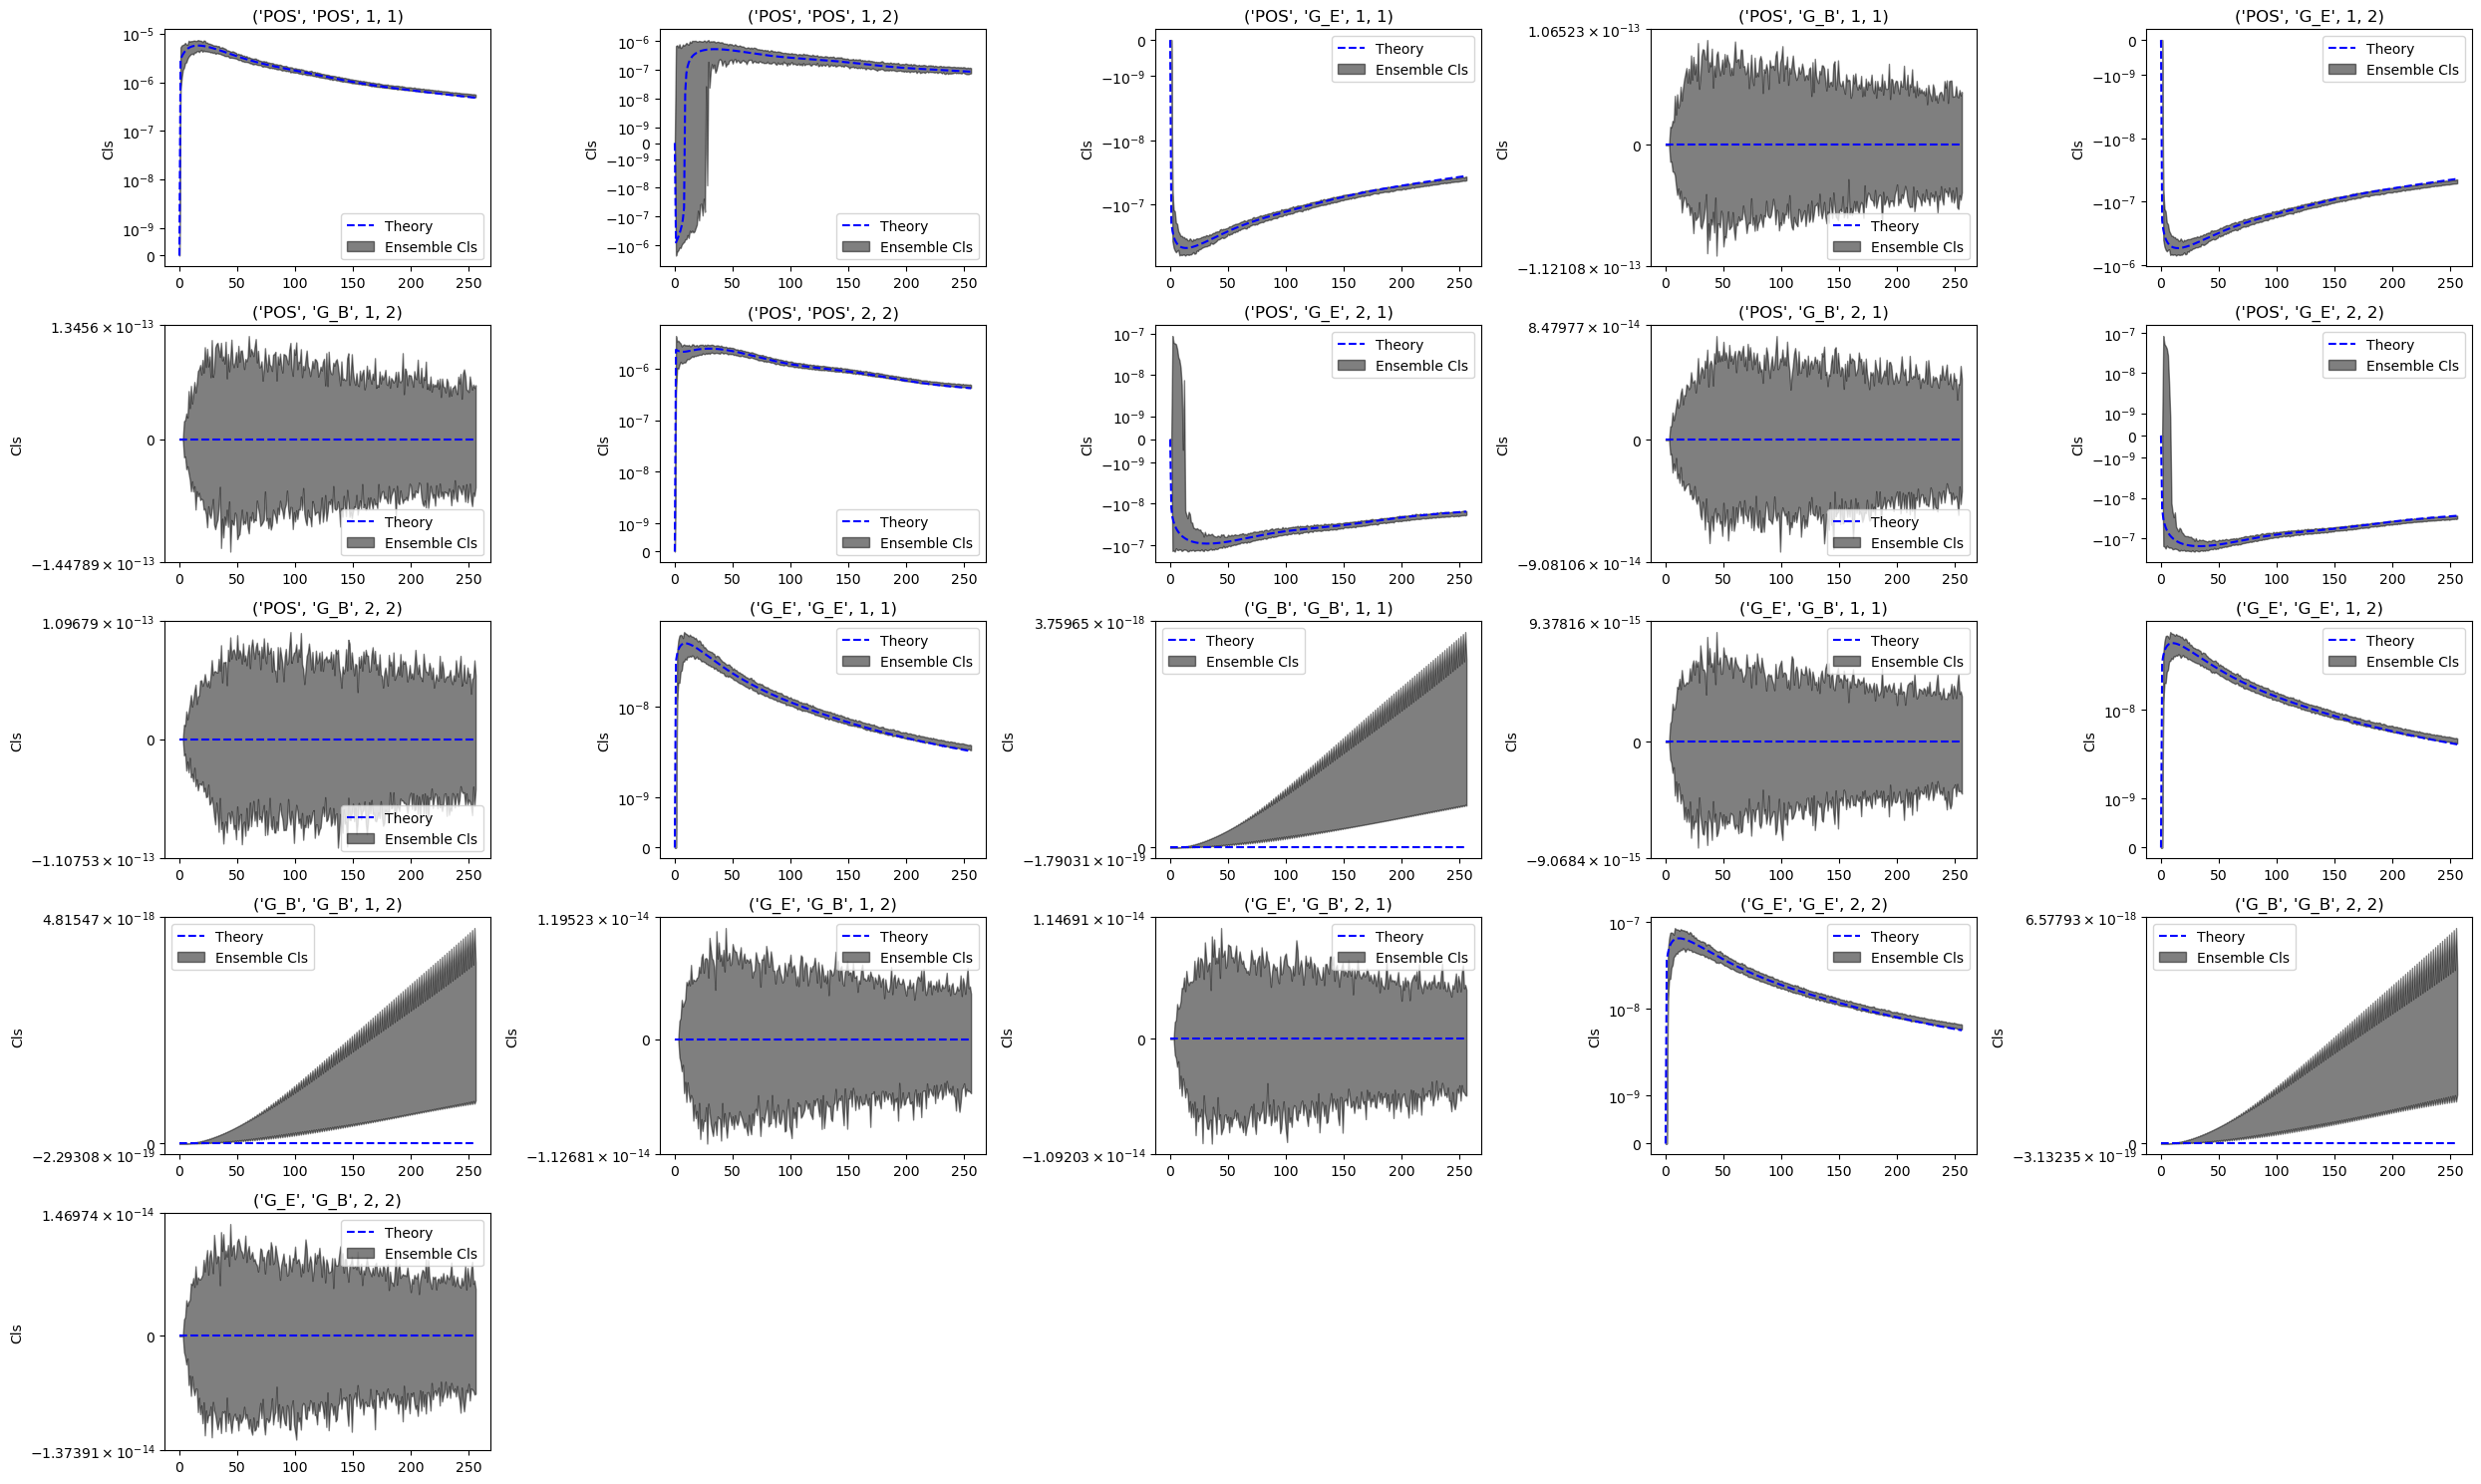

In [18]:
# Determine the number of subplots needed
num_plots = len(cls1_m)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 15))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each Cls with error bars
for (ax, key) in zip(axes, cls1_m.keys()):
    a, b, na, nb = key
    _vcl = _theory_cls[key]
    _cl = ensemble_cls[key]
    err = np.sqrt(np.diag(ensemble_cov[key]))
    ax.plot(ls, _vcl, 'b--', alpha=1.0, label='Theory')
    ax.fill_between(ls, _cl-err, _cl+err, color="k", alpha=0.5, label='Ensemble Cls')
    ax.legend()
    ax.set_title(f'{key}')
    ax.set_ylabel('Cls')
    ax.set_yscale('symlog', linthresh=1e-9, linscale=0.5)

# Hide any unused subplots
for ax in axes[len(cls1_m):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

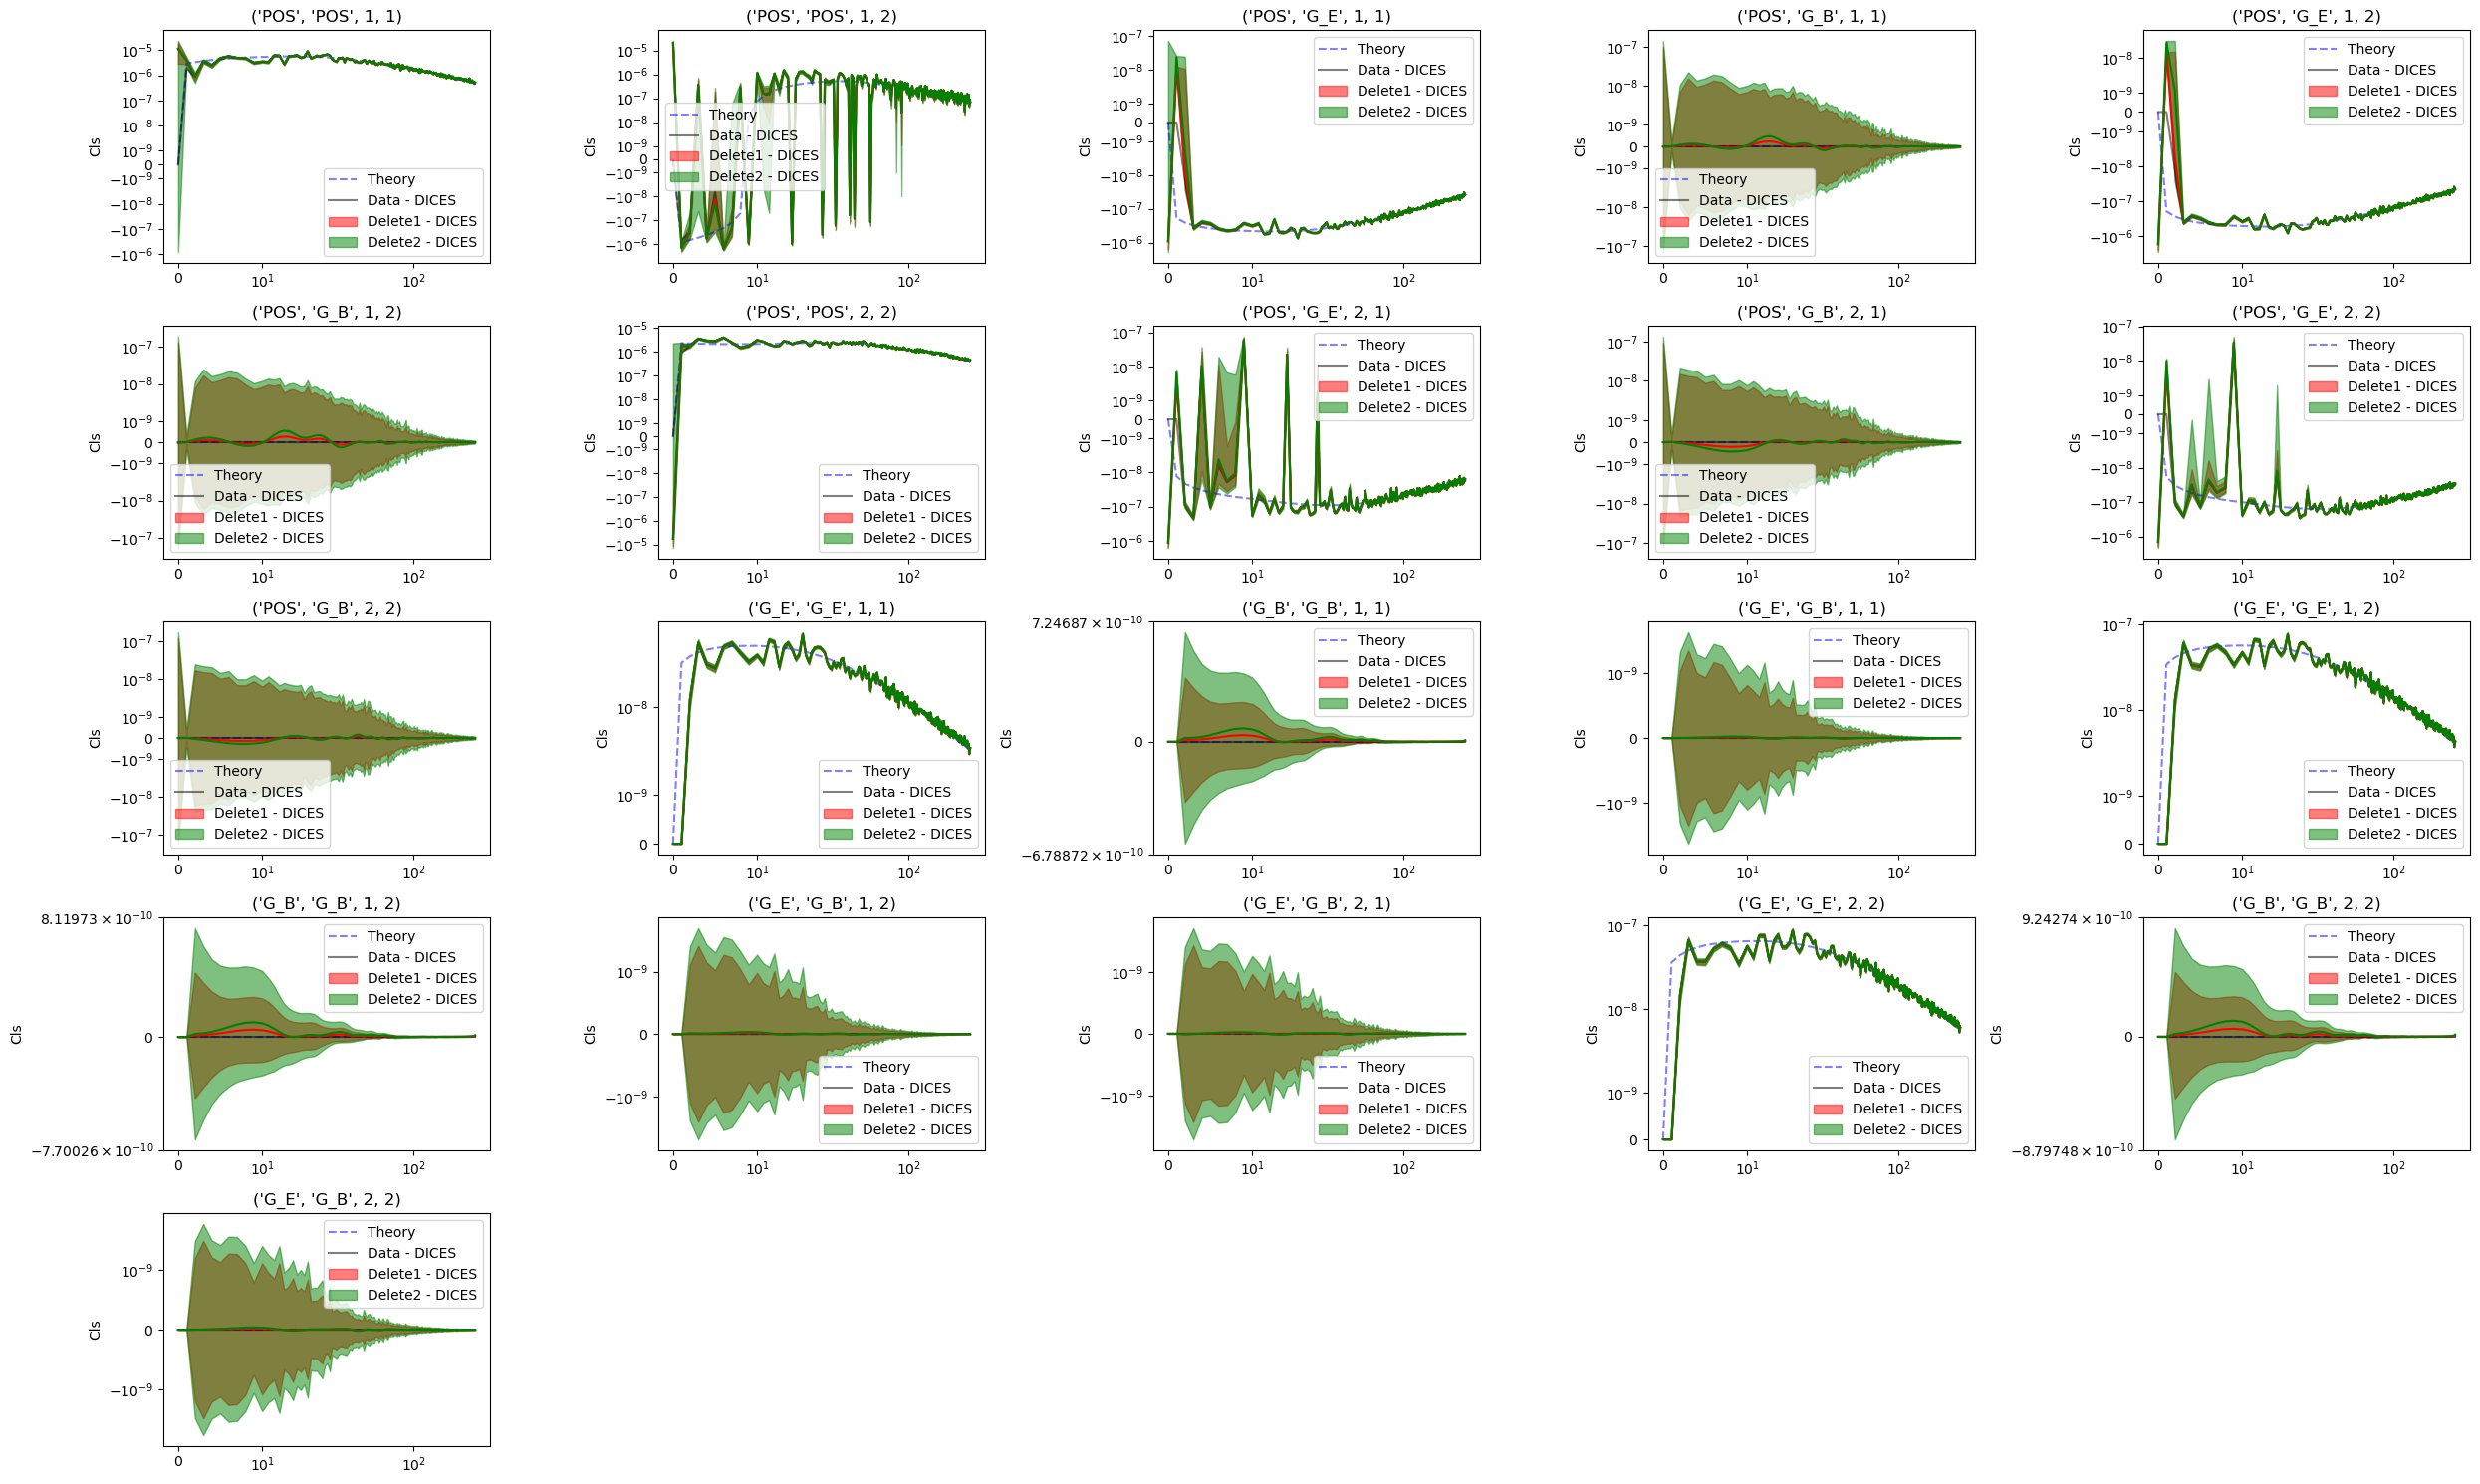

In [19]:
# Determine the number of subplots needed
num_plots = len(cls1_m)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 15))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each Cls with error bars
for (ax, key) in zip(axes, cls1_m.keys()):
    a, b, na, nb = key
    _vcl = _theory_cls[key]
    _cl = cls0[key]
    cl1m = cls1_m[key]
    cl1s = cls1_s[key]
    cl2m = cls2_m[key]
    cl2s = cls2_s[key]
    ax.plot(ls, _vcl, 'b--', alpha=0.5, label='Theory')
    ax.plot(ls, _cl, 'k-', alpha=0.5, label='Data - DICES')
    ax.plot(ls, cl1m, 'r-')
    ax.fill_between(ls, cl1m - cl1s, cl1m + cl1s, color='r', alpha=0.5, label='Delete1 - DICES')
    ax.plot(ls, cl2m, 'g-')
    ax.fill_between(ls, cl2m - cl2s, cl2m + cl2s, color='g', alpha=0.5, label='Delete2 - DICES')
    ax.legend()
    ax.set_title(f'{key}')
    ax.set_ylabel('Cls')
    ax.set_xscale('symlog', linthresh=10, linscale=0.5)
    ax.set_yscale('symlog', linthresh=1e-9, linscale=0.5)

# Hide any unused subplots
for ax in axes[len(cls1_m):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

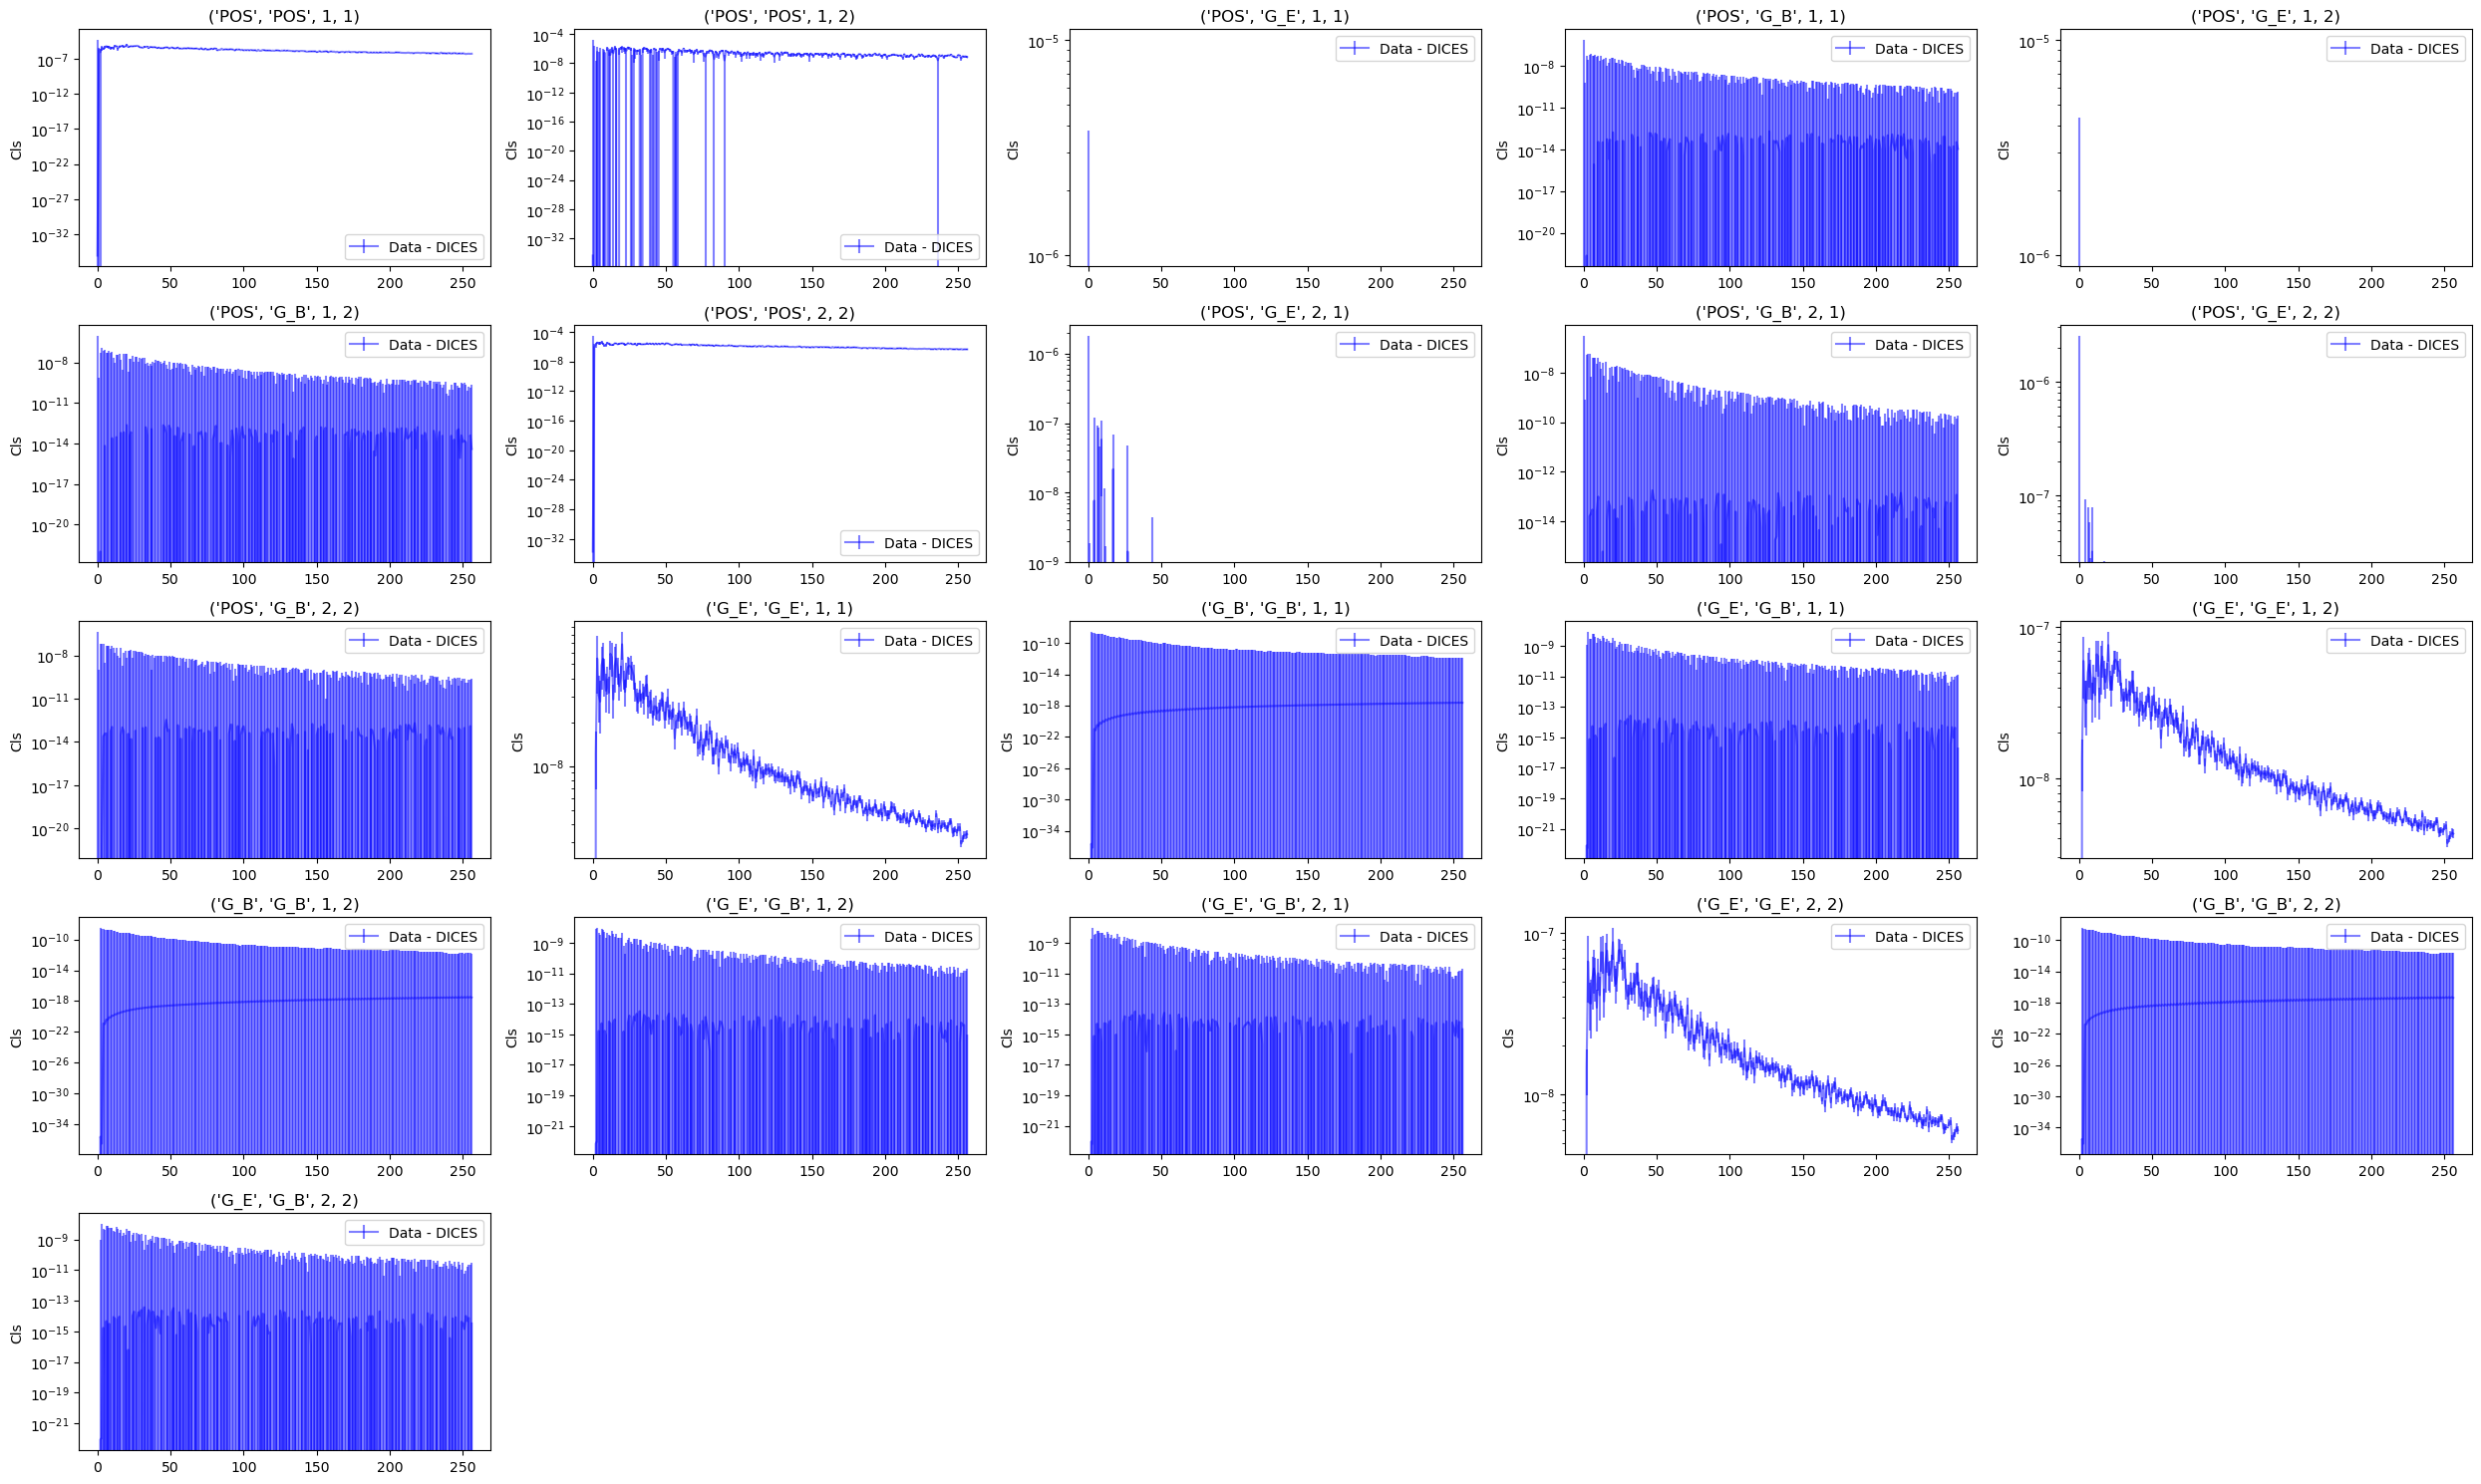

In [20]:
# Determine the number of subplots needed
num_plots = len(cls1_m)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 15))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each Cls with error bars
for (ax, key) in zip(axes, cls1_m.keys()):
    f1, f2, b1, b2 = key
    #_vcl = vcls[key]
    _cl = cls0[key]
    kk = (f1, f2, f1, f2, b1, b2, b1, b2)
    dices_c = dices_cov[kk]
    dices_err = np.sqrt(np.diag(dices_c))
    #ax.plot(ls, _vcl, 'k-', alpha=0.5, label='Theory')
    ax.errorbar(ls, _cl, yerr=dices_err, color="blue", alpha=0.5, label='Data - DICES')
    ax.legend()
    ax.set_title(f'{key}')
    ax.set_ylabel('Cls')
    ax.set_yscale('log')

# Hide any unused subplots
for ax in axes[len(cls1_m):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

/tmp/ipykernel_146241/4215018842.py:23: RuntimeWarning: invalid value encountered in sqrt
  c2err = np.sqrt(np.diag(c2))


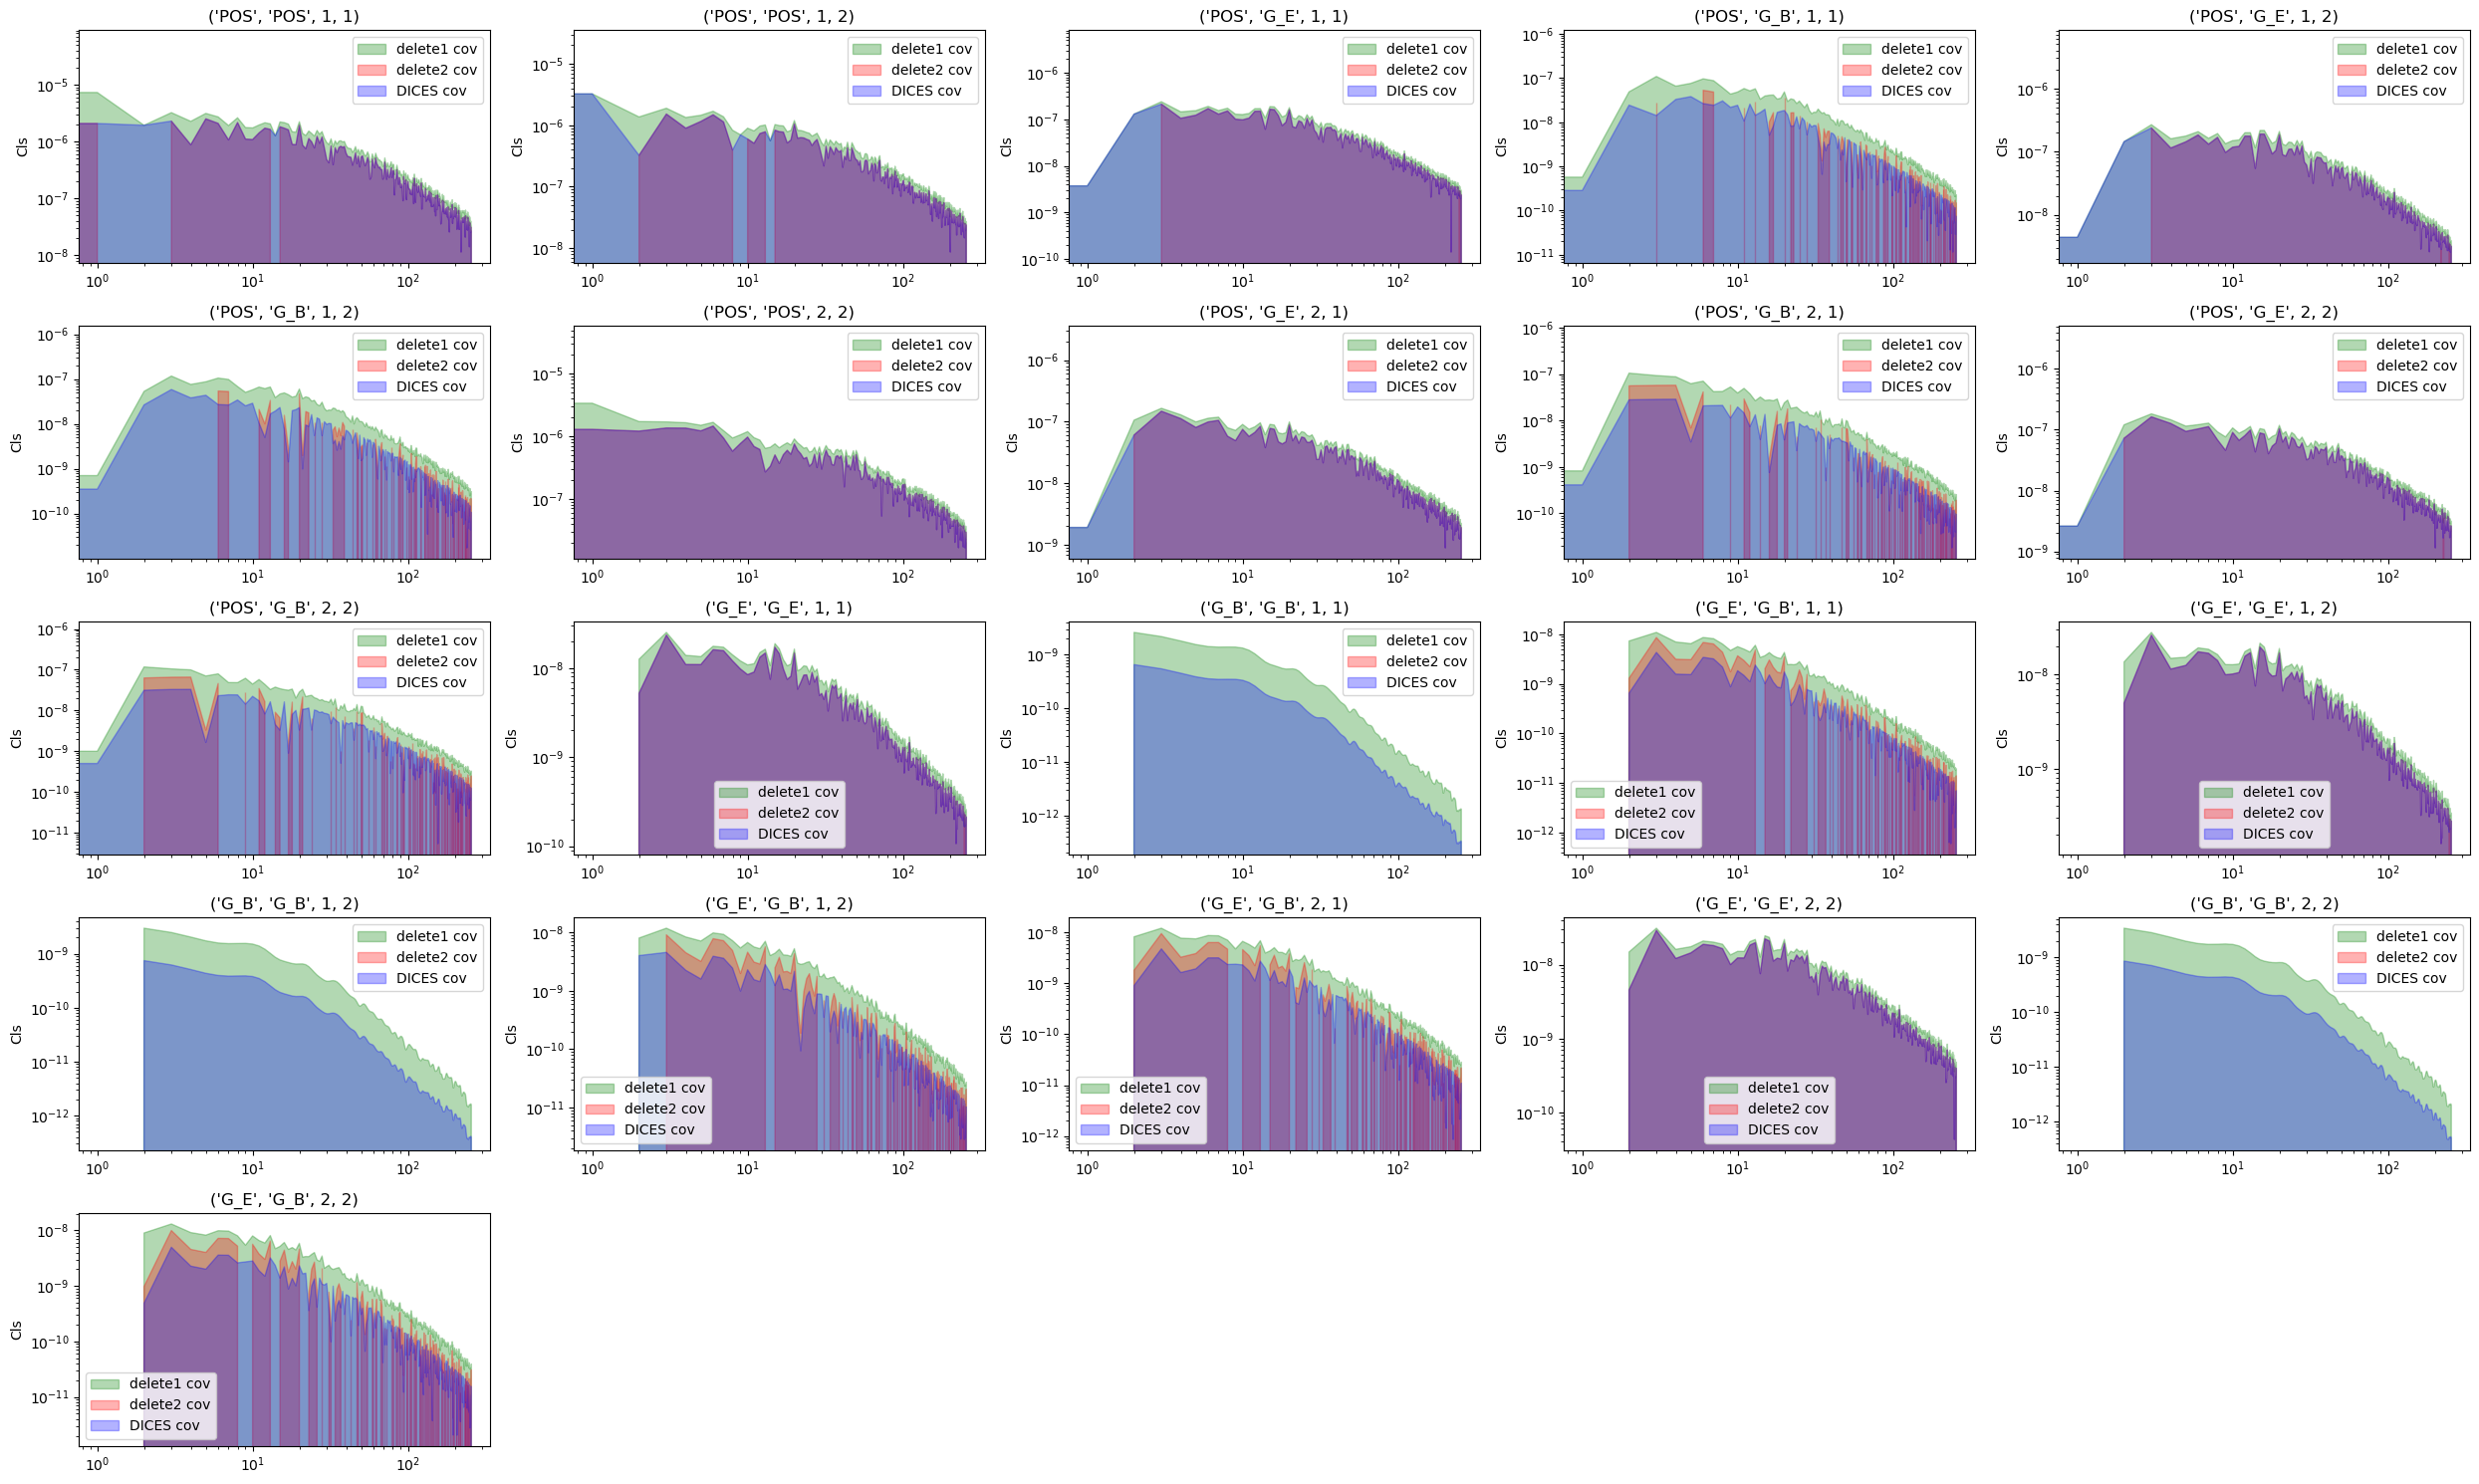

In [21]:
# Determine the number of subplots needed
num_plots = len(cls1_m)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 15))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each Cls with error bars
for ax, (key, value) in zip(axes, cls1_m.items()):
    f1, f2, b1, b2 = key
    kk = (f1, f2, f1, f2, b1, b2, b1, b2)
    _vcl = _theory_cls[key].__array__()
    c = cov1[kk]
    sc = shrunk_cov1[kk]
    c2 = cov2[kk]
    dc = dices_cov[kk]
    #vc = vcov[kk]
    err = np.sqrt(np.diag(c))
    serr = np.sqrt(np.diag(sc))
    c2err = np.sqrt(np.diag(c2))
    dcerr = np.sqrt(np.diag(dc))
    #verr = np.sqrt(vc)
    if f1 == "G_B":
        dcerr /= 2
    if f2 == "G_B":
        dcerr /= 2
    #ax.plot(ls, verr, 'k--', lw=3,label='Gaussian Error w/ bias')
    ax.fill_between(ls, np.zeros_like(ls), err, color='green', alpha=0.3, label='delete1 cov')
    ax.fill_between(ls, np.zeros_like(ls), c2err, color='red', alpha=0.3, label='delete2 cov')
    ax.fill_between(ls, np.zeros_like(ls), dcerr, color='blue', alpha=0.3, label='DICES cov')
    
    ax.set_title(f'{key}')
    ax.legend()
    ax.set_ylabel('Cls')
    ax.loglog()

# Hide any unused subplots
for ax in axes[len(cls1_m):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

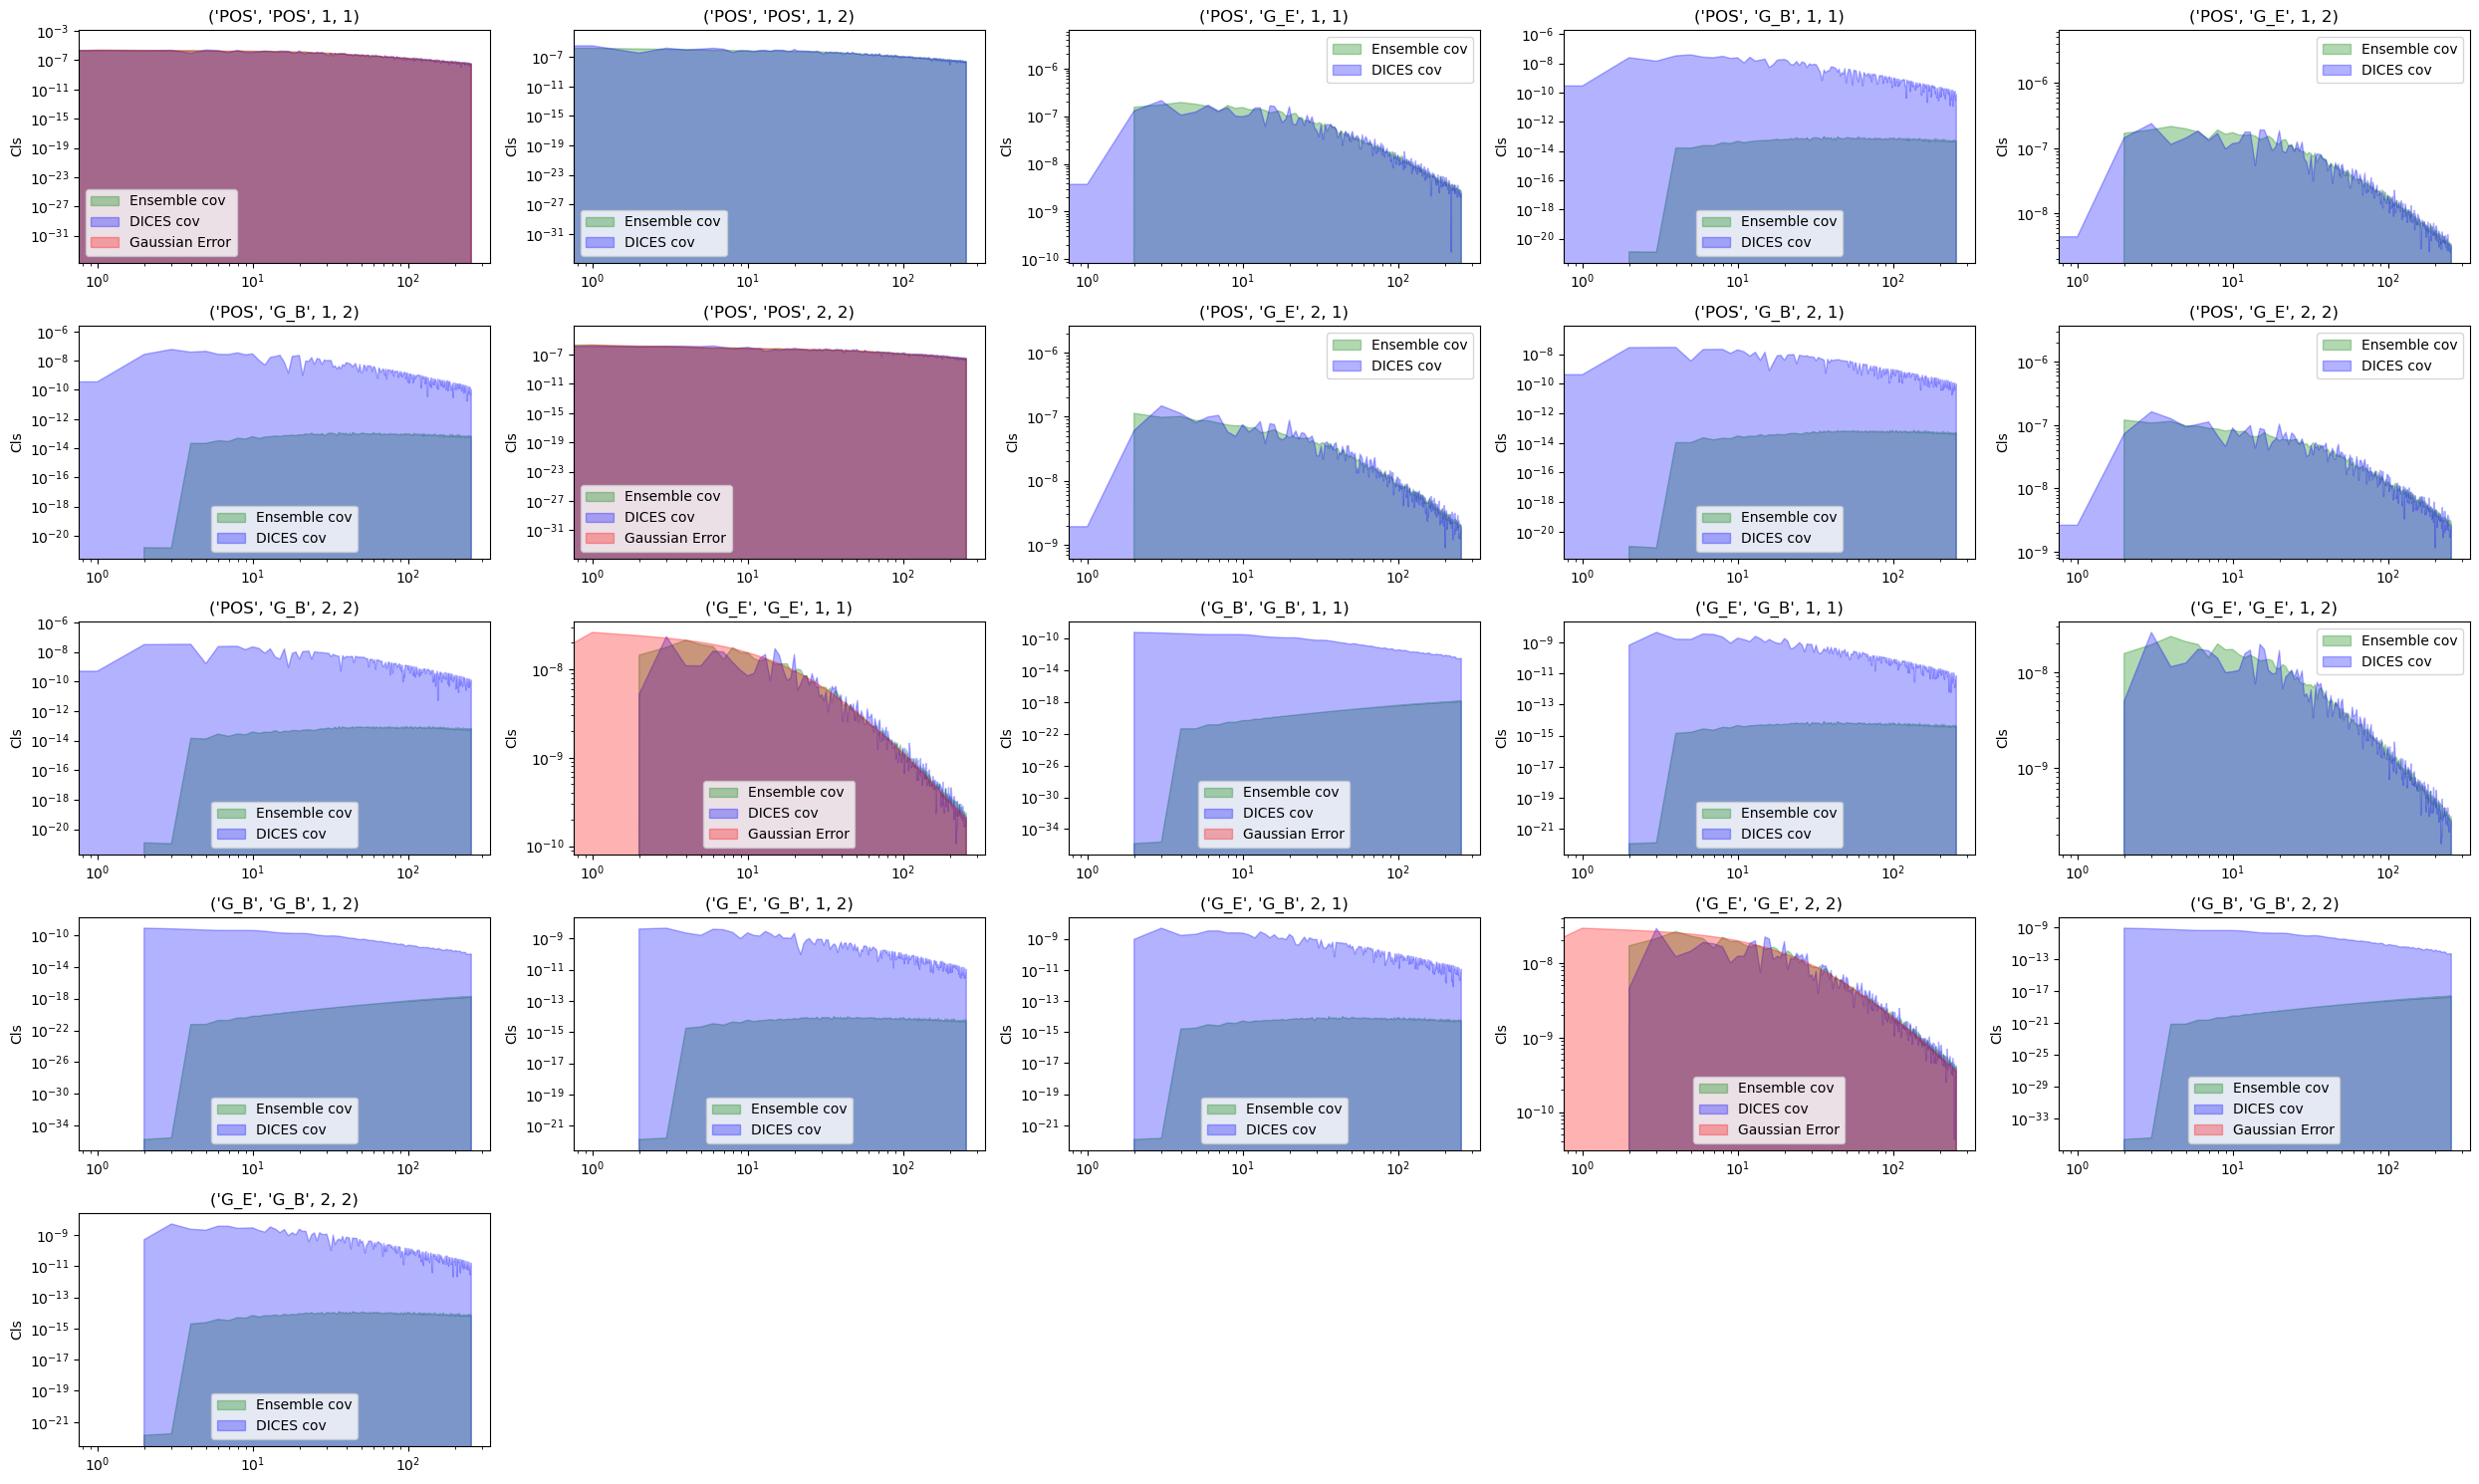

In [22]:
# Determine the number of subplots needed
num_plots = len(cls1_m)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 15))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each Cls with error bars
for ax, (key, value) in zip(axes, cls1_m.items()):
    f1, f2, b1, b2 = key
    kk = (f1, f2, f1, f2, b1, b2, b1, b2)
    _vcl = _theory_cls[key].__array__()
    dc = dices_cov[kk]
    ens_err = np.sqrt(np.diag(ensemble_cov[key]))
    dcerr = np.sqrt(np.diag(dc))
    if f1 == "G_B":
        dcerr /= 2
    if f2 == "G_B":
        dcerr /= 2
    ax.fill_between(ls, np.zeros_like(ls), ens_err, color='green', alpha=0.3, label='Ensemble cov')
    ax.fill_between(ls, np.zeros_like(ls), dcerr, color='blue', alpha=0.3, label='DICES cov')
    if (f1, b1) == (f2, b2):
        ax.fill_between(ls, np.zeros_like(ls), np.sqrt((2*_vcl**2)/(2*ls+1)), color='red', alpha=0.3, label='Gaussian Error')
    
    ax.set_title(f'{key}')
    ax.legend()
    ax.set_ylabel('Cls')
    ax.loglog()

# Hide any unused subplots
for ax in axes[len(cls1_m):]:
    ax.axis('off')

plt.tight_layout()
plt.show()